
=== Random Forest Classifier with Hyperparameter Tuning ===
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END max_depth=17, min_samples_split=9, n_estimators=160; total time=   1.2s
[CV] END max_depth=17, min_samples_split=9, n_estimators=160; total time=   1.1s
[CV] END max_depth=17, min_samples_split=9, n_estimators=160; total time=   1.1s
[CV] END max_depth=11, min_samples_split=9, n_estimators=170; total time=   1.0s
[CV] END max_depth=11, min_samples_split=9, n_estimators=170; total time=   1.1s
[CV] END max_depth=11, min_samples_split=9, n_estimators=170; total time=   1.0s
[CV] END .max_depth=9, min_samples_split=9, n_estimators=100; total time=   0.5s
[CV] END .max_depth=9, min_samples_split=9, n_estimators=100; total time=   0.5s
[CV] END .max_depth=9, min_samples_split=9, n_estimators=100; total time=   0.5s
[CV] END max_depth=19, min_samples_split=5, n_estimators=130; total time=   0.9s
[CV] END max_depth=19, min_samples_split=5, n_estimators=130; total

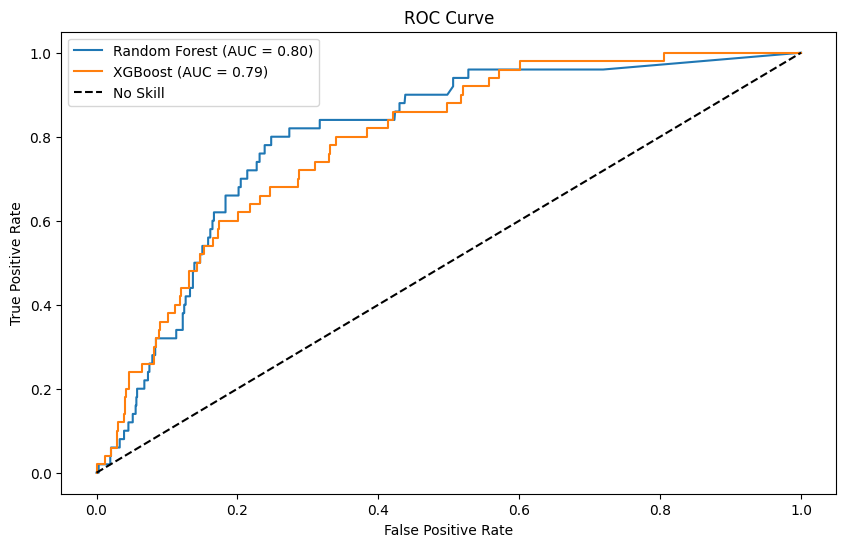


Model terbaik telah disimpan sebagai '../models/stroke_best_model.pkl'


In [38]:
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# ====================
# 1. Memuat Data dan Preprocessing
# ====================
processed_data = pd.read_pickle('../data/processed_data.pkl')  # Membaca file pickle berisi data yang sudah di-preprocessing
X_train = processed_data['X_train']  # Data fitur untuk pelatihan
X_test = processed_data['X_test']  # Data fitur untuk pengujian
y_train = processed_data['y_train']  # Target label untuk pelatihan
y_test = processed_data['y_test']  # Target label untuk pengujian

# Mengatasi nilai NaN
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Menyeimbangkan dataset menggunakan SMOTE + RandomUnderSampler
smote = SMOTE(random_state=42)
undersampler = RandomUnderSampler(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
X_train_bal, y_train_bal = undersampler.fit_resample(X_train_sm, y_train_sm)

# ====================
# 2. Random Forest Classifier dengan Hyperparameter Tuning
# ====================
print("\n=== Random Forest Classifier with Hyperparameter Tuning ===")
param_dist = {
    'n_estimators': np.arange(50, 200, 10),
    'max_depth': np.arange(5, 20, 2),
    'min_samples_split': np.arange(2, 10),
}
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=50, cv=3, scoring='roc_auc', random_state=42, verbose=2
)
random_search.fit(X_train_bal, y_train_bal)
rf_best_model = random_search.best_estimator_
rf_pred = rf_best_model.predict(X_test)

# Evaluasi
rf_proba = rf_best_model.predict_proba(X_test)[:, 1]
rf_roc_auc = roc_auc_score(y_test, rf_proba)
print("Random Forest ROC-AUC:", rf_roc_auc)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

# ====================
# 3. XGBoost Classifier
# ====================
print("\n=== XGBoost Classifier ===")
xgb_model = XGBClassifier(n_estimators=150, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)
xgb_pred = xgb_model.predict(X_test)

# Evaluasi
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_roc_auc = roc_auc_score(y_test, xgb_proba)
print("XGBoost ROC-AUC:", xgb_roc_auc)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

# ====================
# 4. Plot ROC Curve
# ====================
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_roc_auc:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {xgb_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="No Skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ====================
# 5. Menyimpan Model Terbaik
# ====================
best_model = rf_best_model if rf_roc_auc > xgb_roc_auc else xgb_model
joblib.dump(best_model, '../models/stroke_best_model.pkl')
print("\nModel terbaik telah disimpan sebagai '../models/stroke_best_model.pkl'")


In [ ]:
# import joblib
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, accuracy_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.impute import SimpleImputer
# from imblearn.over_sampling import SMOTE
# import pandas as pd

# # ====================
# # 1. Memuat Data dan Preprocessing
# # ====================
# processed_data = pd.read_pickle('../data/processed_data.pkl')  # Membaca file pickle berisi data yang sudah di-preprocessing
# X_train = processed_data['X_train']  # Data fitur untuk pelatihan
# X_test = processed_data['X_test']  # Data fitur untuk pengujian
# y_train = processed_data['y_train']  # Target label untuk pelatihan
# y_test = processed_data['y_test']  # Target label untuk pengujian

# # Mengatasi nilai NaN
# imputer = SimpleImputer(strategy='mean')
# X_train = imputer.fit_transform(X_train)
# X_test = imputer.transform(X_test)

# # Menyeimbangkan dataset menggunakan SMOTE
# smote = SMOTE(random_state=42)
# X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# # ====================
# # 2. Decision Tree Classifier
# # ====================
# print("=== Decision Tree Classifier ===")
# dt_model = DecisionTreeClassifier(random_state=42)
# dt_model.fit(X_train_sm, y_train_sm)
# dt_pred = dt_model.predict(X_test)
# print("Decision Tree Accuracy:", accuracy_score(y_test, dt_pred))
# print(classification_report(y_test, dt_pred))

# # ====================
# # 3. Random Forest Classifier
# # ====================
# print("\n=== Random Forest Classifier ===")
# rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
# rf_model.fit(X_train_sm, y_train_sm)
# rf_pred = rf_model.predict(X_test)
# print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
# print(classification_report(y_test, rf_pred))

# # ====================
# # 4. Logistic Regression
# # ====================
# print("\n=== Logistic Regression ===")
# lr_model = LogisticRegression(random_state=42, max_iter=200)
# lr_model.fit(X_train_sm, y_train_sm)
# lr_pred = lr_model.predict(X_test)
# print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
# print(classification_report(y_test, lr_pred))

# # ====================
# # 5. Gradient Boosting
# # ====================
# print("\n=== Gradient Boosting ===")
# gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# gb_model.fit(X_train_sm, y_train_sm)
# gb_pred = gb_model.predict(X_test)
# print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_pred))
# print(classification_report(y_test, gb_pred))

# # ====================
# # 6. Hyperparameter Tuning (Random Forest)
# # ====================
# print("\n=== Hyperparameter Tuning with GridSearchCV (Random Forest) ===")
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10]
# }
# grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
#                            param_grid=param_grid,
#                            cv=3, scoring='accuracy', verbose=2)
# grid_search.fit(X_train_sm, y_train_sm)
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_
# print("Best Parameters:", best_params)
# print("Best Model Accuracy:", accuracy_score(y_test, best_model.predict(X_test)))

# # ====================
# # 7. Menyimpan Model Terbaik
# # ====================
# joblib.dump(best_model, '../models/stroke_model.pkl')
# print("\nModel terbaik telah disimpan sebagai '../models/stroke_model.pkl'")


=== Decision Tree Classifier ===
Decision Tree Accuracy: 0.840122199592668
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       929
           1       0.11      0.28      0.16        53

    accuracy                           0.84       982
   macro avg       0.53      0.58      0.54       982
weighted avg       0.91      0.84      0.87       982


=== Random Forest Classifier ===
Random Forest Accuracy: 0.8289205702647657
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       929
           1       0.15      0.47      0.23        53

    accuracy                           0.83       982
   macro avg       0.56      0.66      0.57       982
weighted avg       0.92      0.83      0.87       982


=== Logistic Regression ===
Logistic Regression Accuracy: 0.7505091649694501
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       929
       

In [30]:
print("Distribusi kelas sebelum SMOTE:", y_train.value_counts())
print("Distribusi kelas setelah SMOTE:", pd.Series(y_train_sm).value_counts())


Distribusi kelas sebelum SMOTE: stroke
0    3771
1     156
Name: count, dtype: int64
Distribusi kelas setelah SMOTE: stroke
0    3771
1    3771
Name: count, dtype: int64


In [31]:
from sklearn.metrics import f1_score, roc_auc_score

print("F1 Score (Decision Tree):", f1_score(y_test, dt_pred))
print("ROC-AUC Score (Decision Tree):", roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1]))


F1 Score (Decision Tree): 0.16042780748663102
ROC-AUC Score (Decision Tree): 0.5774620712066129


In [32]:
smote = SMOTE(random_state=42, sampling_strategy=0.5)  # Contoh: hanya menyeimbangkan hingga rasio 50%
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [33]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Gunakan metrik yang sesuai
    verbose=2
)
grid_search.fit(X_train_sm, y_train_sm)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=150; total time=   0.5s
[CV] END .max_depth=5, min_samples_split=2, n_e

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='roc_auc', verbose=2)

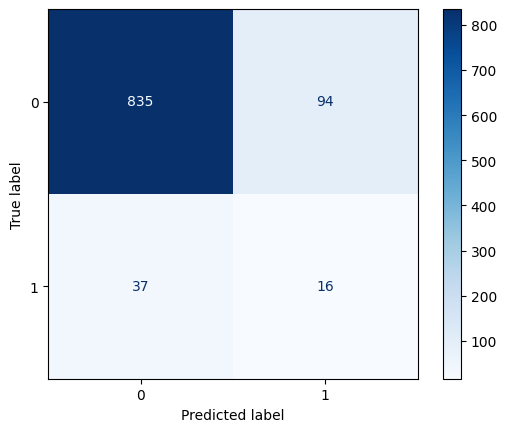

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prediksi model
y_pred = best_model.predict(X_test)

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasikan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


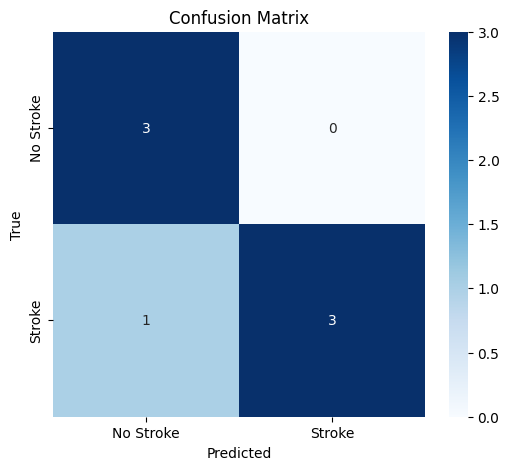

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Misal, y_test adalah label yang benar dan y_pred adalah prediksi model
y_test = [0, 1, 0, 1, 1, 0, 1]  # Contoh data
y_pred = [0, 1, 0, 0, 1, 0, 1]  # Contoh prediksi model

cm = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Stroke", "Stroke"], yticklabels=["No Stroke", "Stroke"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
